# Question Define

- Confirm that the test is actually negative. That is, it appears that the old version of the site with just one translation across Spain and LatAm performs better 
- Explain why that might be happening. Are the localized translations really worse?
- If you identified what was wrong, design an algorithm that would return FALSE if the same problem is happening in the future and TRUE if everything is good and the results can be trusted.

## Hypothesis

- H0: No difference between the test group and reference group
- H1: Significant difference between the two groups 

## Metric

- Conversion: the label can be 0 or 1

# Implementation

In [81]:
import pandas as pd
from scipy import stats

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [23]:
import warnings
warnings.filterwarnings("ignore")

## Load data tables

In [2]:
df_test = pd.read_csv('test_table.csv')
df_user = pd.read_csv('user_table.csv')

In [3]:
df_test.head()

,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test
0,315281,12/3/2015,Direct,Web,ES,NaN,IE,1,0
1,497851,12/4/2015,Ads,Web,ES,Google,IE,0,1
2,848402,12/4/2015,Ads,Web,ES,Facebook,Chrome,0,0
3,290051,12/3/2015,Ads,Mobile,Other,Facebook,Android_App,0,1
4,548435,11/30/2015,Ads,Web,ES,Google,FireFox,0,1


In [4]:
df_user.head()

,user_id,sex,age,country
0,765821,M,20,Mexico
1,343561,F,27,Nicaragua
2,118744,M,23,Colombia
3,987753,F,27,Venezuela
4,554597,F,20,Spain


In [6]:
df_user.shape

(452867, 4)

### Record diff
Neither table includes duplicated records.

test_table.csv has 454 additional user ids than user_table.

In [14]:
print(df_test.shape)
print(len(set(df_test.user_id)))

(453321, 9)
453321


In [15]:
print(df_user.shape)
print(len(set(df_user.user_id)))

(452867, 4)
452867


In [13]:
print(set(df_user.user_id) - set(df_test.user_id))
print(len(set(df_test.user_id) - set(df_user.user_id)))

set()
454


### Merge table

We can choose different ways to handle the additional 454 rows:
- Ignore them directly, since it's really a small propotion of the data
- Leave them, and exclude them in calcusion for sex, age and country fields

Now, I will just keep them as they are.

In [19]:
df = df_test.merge(df_user, how='left')
print(df.shape)
df.head()

(453321, 12)


,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test,sex,age,country
0,315281,12/3/2015,Direct,Web,ES,NaN,IE,1,0,M,32.0,Spain
1,497851,12/4/2015,Ads,Web,ES,Google,IE,0,1,M,21.0,Mexico
2,848402,12/4/2015,Ads,Web,ES,Facebook,Chrome,0,0,M,34.0,Spain
3,290051,12/3/2015,Ads,Mobile,Other,Facebook,Android_App,0,1,F,22.0,Mexico
4,548435,11/30/2015,Ads,Web,ES,Google,FireFox,0,1,M,19.0,Mexico


### Unbalanced sample design

- Uruguay and Argentina show obvious unbalance in experiment design of having insufficient reference samples

In [60]:
sample_sizes = df[['country', 'test', 'conversion']].groupby(['country', 'test']).count().reset_index().pivot(index='country', columns='test').reset_index()
sample_sizes['ratio'] = sample_sizes[('conversion', 0)] / sample_sizes[('conversion', 1)]
sample_sizes.sort_values(by='ratio')

country conversion              ratio
test                       0        1          
15        Uruguay      415.0   3719.0  0.111589
0       Argentina     9356.0  37377.0  0.250314
12       Paraguay     3650.0   3697.0  0.987287
11         Panama     1966.0   1985.0  0.990428
1         Bolivia     5550.0   5574.0  0.995694
2           Chile     9853.0   9884.0  0.996864
9          Mexico    64209.0  64275.0  0.998973
4      Costa Rica     2660.0   2649.0  1.004153
13           Peru    16869.0  16797.0  1.004286
3        Colombia    27088.0  26972.0  1.004301
6     El Salvador     4108.0   4067.0  1.010081
16      Venezuela    16149.0  15905.0  1.015341
7       Guatemala     7622.0   7503.0  1.015860
5         Ecuador     8036.0   7859.0  1.022522
10      Nicaragua     3419.0   3304.0  1.034806
8        Honduras     4361.0   4207.0  1.036606
14          Spain    51782.0      NaN       NaN

### Visualize the difference of different segments

<AxesSubplot:xlabel='country', ylabel='conversion'>

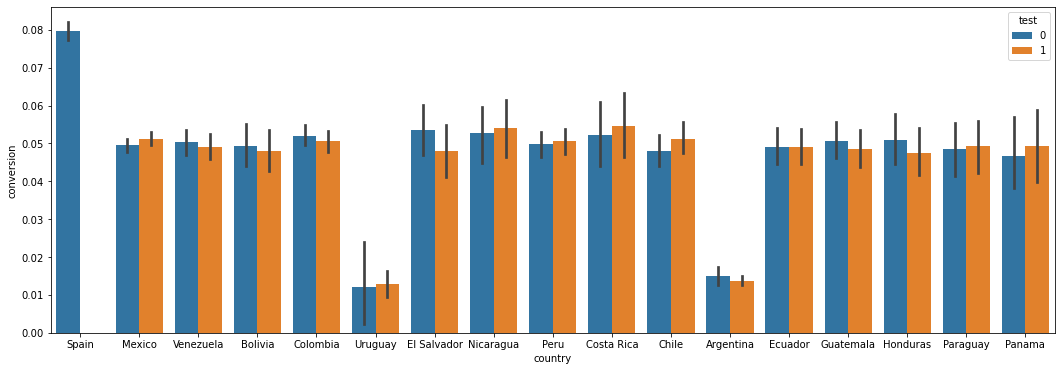

In [26]:
plt.figure(figsize=(18, 6))
sns.barplot(x='country',y='conversion',hue='test',data=df)

**!! Exclude unbalanced or irrelavant data**

In [72]:
df = df[df.country!='Spain']
df = df[df.country!='Uruguay']
df = df[df.country!='Argentina']
df.shape

(350672, 12)

<AxesSubplot:xlabel='sex', ylabel='conversion'>

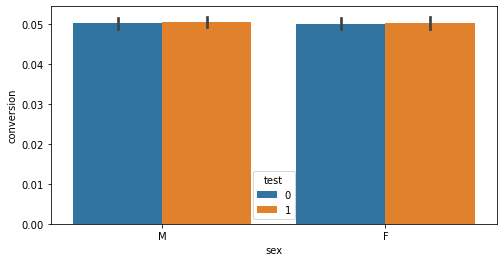

In [73]:
plt.figure(figsize=(8, 4))
sns.barplot(x='sex',y='conversion',hue='test',data=df)

<AxesSubplot:xlabel='source', ylabel='conversion'>

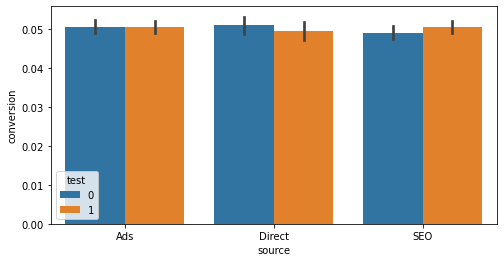

In [74]:
plt.figure(figsize=(8, 4))
sns.barplot(x='source',y='conversion',hue='test',data=df)

<AxesSubplot:xlabel='device', ylabel='conversion'>

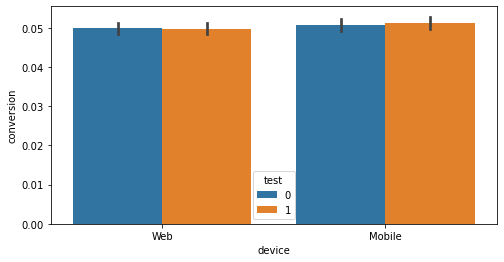

In [75]:
plt.figure(figsize=(8, 4))
sns.barplot(x='device',y='conversion',hue='test',data=df)

<AxesSubplot:xlabel='date', ylabel='conversion'>

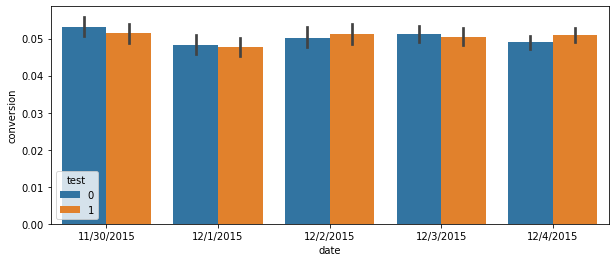

In [80]:
plt.figure(figsize=(10, 4))
sns.barplot(x='date',y='conversion',hue='test',data=df.sort_values(by='date'))

# Enough Sample Size?

In [112]:
# Power test to determine sample size for a certain stat power & significance level:
def sample_power_probtest(p1, p2, power=0.8, sig=0.05):
    z = stats.norm.isf([sig/2]) #two-sided t test
    zp = -1 * stats.norm.isf([power]) 
    d = (p1-p2)
    s =2*((p1+p2) /2)*(1-((p1+p2) /2))
    n = s * ((zp + z)**2) / (d**2)
    return int(round(n[0]))

p1 = df[df['test']==1]['conversion'].mean()
p2 = df[df['test']==0]['conversion'].mean()
sample_power_probtest(p1, p2)

13600196

According to the calculation of the above function, we need 13,600,196 samples to get a solide conclusion, which is far more than what we have at hand.

In [114]:
print(p1, p2)
print(len(df))

0.05042112907191501 0.05018630713655887
350672


# AB-Test / tTest

In [85]:
# statistic = (list(stats.ttest_ind(dated_data[dated_data.test == 1].conversion,
#                           dated_data[dated_data.test == 0].conversion)))
result = stats.ttest_ind(df[df.test == 1].conversion, df[df.test == 0].conversion)
print('p-value: ', result[1])

p-value:  0.7504082947797941


In [106]:
# Compute t-test for each segment of the experiment and display them in lists along with p-values
def get_ttest_pvalue(df, val):
    statistic_list = []
    for v in sorted(df[val].unique(), key=str):
        df_v = df[df[val] == v]
        statistic = (list(stats.ttest_ind(df_v[df_v.test == 1].conversion,
                            df_v[df_v.test == 0].conversion)))
        statistic[1] = "%.16f" % statistic[1]
        statistic_list.append(statistic)
        print(v, ': ', statistic[1])


In [107]:
get_ttest_pvalue(df, 'country')

Bolivia :  0.7188769243244486
Chile :  0.3028707161366122
Colombia :  0.4237329893677158
Costa Rica :  0.6878629303268544
Ecuador :  0.9615123742251157
El Salvador :  0.2482506809738994
Guatemala :  0.5721648004081855
Honduras :  0.4717211680827569
Mexico :  0.1655471793333996
Nicaragua :  0.7803508783178821
Panama :  0.7053611759024120
Paraguay :  0.8837017802593760
Peru :  0.7719499041764490
Venezuela :  0.5737395248962414
nan :  nan


In [109]:
get_ttest_pvalue(df, 'sex')

F :  0.8586822685314282
M :  0.7498372289749360
nan :  nan


In [110]:
get_ttest_pvalue(df, 'source')

Ads :  0.9728251123454477
Direct :  0.3439782656765242
SEO :  0.2510098134125751


In [111]:
get_ttest_pvalue(df, 'device')

Mobile :  0.5803560165543280
Web :  0.9410818100495216


In [108]:
get_ttest_pvalue(df, 'date')

11/30/2015 :  0.3540698118482746
12/1/2015 :  0.7749060566119294
12/2/2015 :  0.6297756468170441
12/3/2015 :  0.6933416604802254
12/4/2015 :  0.1504745493423540


None significant difference is shown on any subsegment.

By now, we cannot couclude that the test is negative, given all the p-values are large, obviously bigger than 0.05.

# Possible problems to cause experiment fault

- Unbalanced sample sizes: Bias has been introduced so that the test/control groups are not really random.

- Length of experiment: We don't have enough data yet.